In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from collections import OrderedDict
import torch
torch.manual_seed(0)
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
from abcd.local.paths import output_path
from abcd.data.read_data import get_subjects_events_sf, add_event_vars, add_subject_vars, filter_events, filter_subjects
import abcd.data.VARS as VARS
from abcd.data.define_splits import SITES, save_restore_sex_fmri_splits
from abcd.data.divide_with_splits import divide_events_by_splits
from abcd.data.var_tailoring.normalization import normalize_var
from abcd.data.pytorch.get_dataset import PandasDataset
from abcd.local.paths import core_path, output_path
from abcd.data.VARS import STRUCT_FILES, STRUCT_FEATURES

# from abcd.training.RegressorTrainer import RegressorTrainer
from abcd.models.regression.LinearRegression import LinearRegressor
# from abcd.models.regression.MLPRegressor import MLPReg3

import matplotlib.pyplot as plt
import pygal
from abcd.plotting.pygal.rendering import display_html

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# visualize data

In [ ]:
data_path = "/Users/carolinezanze/Desktop/housing.csv"

columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(data_path, header=None, delimiter=r"\s+", names=columns)

In [ ]:
df.info()

In [ ]:
# Create a figure and axis for the scatter plots
fig, axs = plt.subplots(5, 3, figsize=(25, 30))
axs = axs.ravel()

# Plot each feature against the target variable
for i, column in enumerate(df.columns[:-1]):
    axs[i].scatter(df[column], df["MEDV"])
    axs[i].set_title(column)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel("MEDV")
    
    # calculate the slope and intercept of the line of best fit
    slope, intercept = np.polyfit(df[column], df["MEDV"], 1)
    x = np.linspace(df[column].min(), df[column].max(), 100)
    y = slope * x + intercept
    
    # plot the line of best fit
    axs[i].plot(x, y, '-r')
    
plt.show()

In [ ]:
sns.pairplot(data=df, x_vars=df.columns[:-1], y_vars=["MEDV"], height=4)
plt.show()

# sklearn linear regression

In [ ]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X = df.loc[:,features]
y = df['MEDV']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Define the models
models = [LinearRegression(), 
        #   DecisionTreeRegressor(), 
        #   RandomForestRegressor(), 
        #   SVR(), 
        #   KNeighborsRegressor(), 
        #   GradientBoostingRegressor()
         ]

# Define the model names
model_names = ['Linear Regression', 
            #    'Decision Tree', 
            #    'Random Forest', 
            #    'Support Vector Regression', 
            #    'KNeighbors Regression', 
            #    'Gradient Boosting Regression'
              ]

In [ ]:
# Define a dictionary to store the model performances
performances = {}

# Train the models and evaluate their performances
for model, name in zip(models, model_names):
    # Train the model
    print("training ", name)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the performance metrics in the dictionary
    performances[name] = [mae, mse, r2]

In [ ]:

print("Mean absolute error(MAE): ", performances['Linear Regression'][0])
print("Mean squared error(MSE): ", performances['Linear Regression'][1])
print("r2_score: ", performances['Linear Regression'][2])

# custom pytorch linear regression without regression trainer

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

In [4]:
data_path = "/Users/carolinezanze/Desktop/housing.csv"

columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(data_path, header=None, delimiter=r"\s+", names=columns)

In [5]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X = df.loc[:,features]
y = df['MEDV']

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

In [8]:
# Create data loaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

In [9]:
# Determine device for training
device = "cpu" #("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using {} device".format(device))

Using cpu device


In [10]:
models_path = os.path.join(output_path, 'ABCD_housing_prediction_reg', 'models')
model = LinearRegressor(save_path=models_path, input_size=X_train_tensor.shape[1])
print(model)

LinearRegressor(
  (linear): Linear(in_features=13, out_features=1, bias=True)
)


In [28]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [29]:
# Train the model
for epoch in range(1000):
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [30]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

In [31]:
# Convert back to numpy arrays
y_pred = y_pred_tensor.numpy()
y_test = y_test_tensor.numpy()


In [32]:
# Calculate the performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [33]:
print("Mean absolute error(MAE): ", mae)
print("Mean squared error(MSE): ", mse)
print("r2_score: ", r2)

Mean absolute error(MAE):  3.320223
Mean squared error(MSE):  27.101921
r2_score:  0.6304306280548111


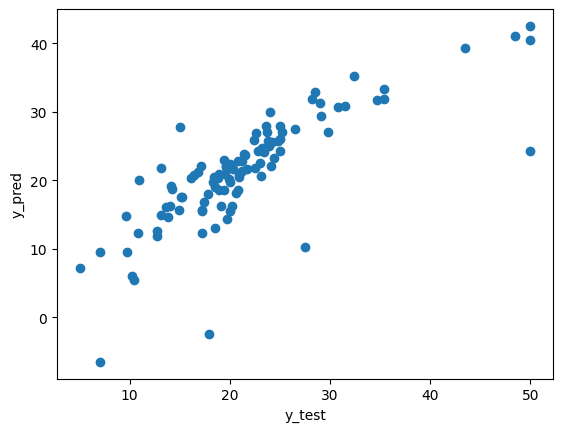

In [36]:
#plot y_pred vs. y_test
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()